# Energy Efficiency Prediction from House Parameters

This study looked into assessing the heating load and cooling load requirements of buildings (that is, energy efficiency) as a function of building parameters.

We perform energy analysis using 12 different building shapes simulated in Ecotect. The buildings differ with respect to the glazing area, the glazing area distribution, and the orientation, amongst other parameters. We simulate various settings as functions of the afore-mentioned characteristics to obtain 768 building shapes. The dataset comprises 768 samples and 8 features, aiming to predict two real valued responses. It can also be used as a multi-class classification problem if the response is rounded to the nearest integer.

This dataset was collected from the UCI Machine Learning Repository.

## Loading Libraries

In [163]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from seaborn import heatmap
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Exploratory Data Analysis

### Loading DataFrame

In [164]:
house_df = pd.read_csv(r"C:\Users\Sebastian\Downloads\energy_efficiency_data.csv")

### Data Appearance and Description

In [165]:
house_df.head()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [166]:
house_df.describe()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


### Checkling for NaN Values

In [167]:
house_df.isnull().sum()

Relative_Compactness         0
Surface_Area                 0
Wall_Area                    0
Roof_Area                    0
Overall_Height               0
Orientation                  0
Glazing_Area                 0
Glazing_Area_Distribution    0
Heating_Load                 0
Cooling_Load                 0
dtype: int64

There are no NaN values - do not have to handle in data preparation.

### Checking for Outliers

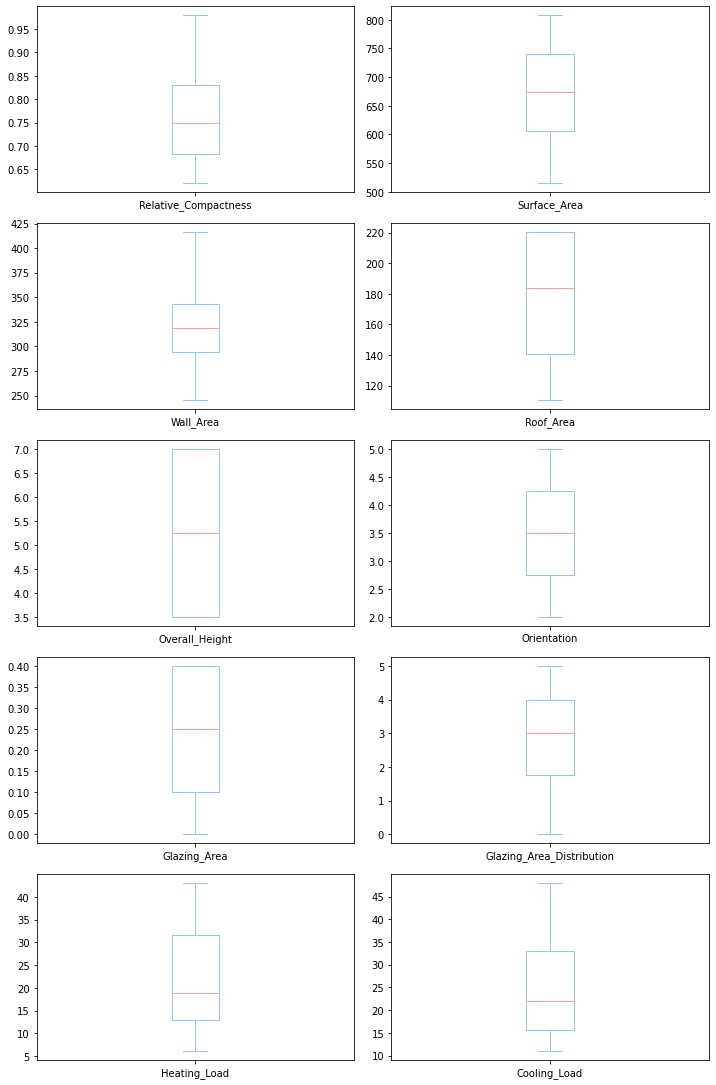

In [168]:
house_df.plot(kind = 'box', subplots = True, layout = (10,2), legend = True, figsize = (10, 30), grid = False)
plt.tight_layout()

There are no outliers - do not have to handle in data preparation.

### Checking DataFrame Correlation

<AxesSubplot:>

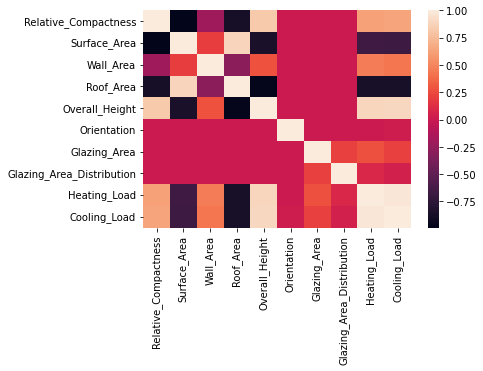

In [169]:
corr = house_df.corr()
heatmap(corr)

There is a strong correlation between input and output variables meaning there is a discernable relationship between the two, allowing accurate predictions to be made. There is some correlation between input variables so variance inflation factors will be calculated during data preparation to account for this. 

## Data Preparation

### Seperating DataFrame into Inputs and Outputs

In [170]:
x = house_df.drop(["Heating_Load", "Cooling_Load"], axis = 1)
y1 = house_df["Heating_Load"]
y2 = house_df["Cooling_Load"]

### VIF Correlation Testing

In [171]:
features = x[x.columns]
features = sm.add_constant(features)
low_variance_columns = [col for col in features.columns if 0 <= features[col].std() < 1e-10]
features = features.drop(columns = low_variance_columns)
corr_matrix = features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
features = features.drop(columns = to_drop)
vif_data = pd.DataFrame()
vif_data['Feature'] = features.columns
vif_data['VIF'] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif_data

,Feature,VIF
0,Relative_Compactness,26.195581
1,Wall_Area,32.237710
2,Roof_Area,11.425453
3,Orientation,10.792374
4,Glazing_Area,4.293307
5,Glazing_Area_Distribution,4.495918


In [172]:
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

vif_data = calculate_vif(features)

while vif_data['VIF'].max() > 10:
    max_vif_feature = vif_data.loc[vif_data['VIF'].idxmax(), 'Feature']
    print(f"Removing {max_vif_feature} with VIF = {vif_data['VIF'].max()}")
    features = features.drop(columns=[max_vif_feature])
    vif_data = calculate_vif(features)

print("Final VIF Data:")
print(vif_data)

Removing Wall_Area with VIF = 32.23770959042737
Removing Relative_Compactness with VIF = 13.851043420125913
Final VIF Data:
                     Feature       VIF
0                  Roof_Area  8.352319
1                Orientation  7.427067
2               Glazing_Area  4.023307
3  Glazing_Area_Distribution  4.185505


In [173]:
x = x.drop(["Wall_Area", "Relative_Compactness"], axis = 1)

Removed two inputs since they are highly multi-colinear with VIF scores of over 10.

### Min-Max Scaling the Input Data

In [174]:
scaler = MinMaxScaler()
scaled_x = scaler.fit_transform(x)
x = pd.DataFrame(scaled_x, columns = x.columns)
x.head()

,Surface_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution
0,0.000000,0.000000,1.0,0.000000,0.0,0.0
1,0.000000,0.000000,1.0,0.333333,0.0,0.0
2,0.000000,0.000000,1.0,0.666667,0.0,0.0
3,0.000000,0.000000,1.0,1.000000,0.0,0.0
4,0.166667,0.111111,1.0,0.000000,0.0,0.0


### Separating Input and Output Data into Training and Testing Data

In [175]:
house_df = pd.concat([x, y1, y2], axis = 1)
d_train, d_test = train_test_split(house_df, test_size = 0.2)
X_train, y1_train, y2_train = d_train.drop(["Heating_Load", "Cooling_Load"], axis = 1), d_train["Heating_Load"], d_train["Cooling_Load"]
X_test, y1_test, y2_test = d_test.drop(["Heating_Load", "Cooling_Load"], axis = 1), d_test["Heating_Load"], d_test["Cooling_Load"]
Y_train = (np.array(y1_train),np.array(y2_train))
Y_test = (np.array(y1_test),np.array(y2_test))

### Defining Model Shape

In [176]:
input_shape = (len(X_train.columns),)
input_layer = Input(shape = input_shape)
first_dense = Dense(units = 128, activation = "relu")(input_layer)
second_dense = Dense(units = 128, activation = "relu")(first_dense)
y1_output = Dense(units = 1, name = "y1_output")(second_dense)
third_dense = Dense(units = 64, activation = "relu")(second_dense)
y2_output = Dense(units = 1, name = "y2_output")(third_dense)
model = Model(inputs = input_layer, outputs = [y1_output, y2_output])

### Defining Neural Network Training Type

In [177]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001)
model.compile(optimizer = optimizer,
              loss = {"y1_output": "mse", "y2_output": "mse"},
              metrics={"y1_output": tf.keras.metrics.RootMeanSquaredError(),
                       "y2_output": tf.keras.metrics.RootMeanSquaredError()})

Chose SGD over Adam optimizer since it is better at generelization performance and converges quicker which is important for this smaller dataset.

### Model Training

In [181]:
history = model.fit(X_train, Y_train, epochs = 100, batch_size = 10, validation_data = (X_test, Y_test))

Epoch 1/100
62/62 [==============================] - 0s 3ms/step - loss: 0.1232 - y1_output_loss: 0.0707 - y2_output_loss: 0.0525 - y1_output_root_mean_squared_error: 0.2659 - y2_output_root_mean_squared_error: 0.2292 - val_loss: 0.5469 - val_y1_output_loss: 0.2140 - val_y2_output_loss: 0.3329 - val_y1_output_root_mean_squared_error: 0.4626 - val_y2_output_root_mean_squared_error: 0.5770
Epoch 2/100
62/62 [==============================] - 0s 3ms/step - loss: 0.1033 - y1_output_loss: 0.0634 - y2_output_loss: 0.0399 - y1_output_root_mean_squared_error: 0.2518 - y2_output_root_mean_squared_error: 0.1997 - val_loss: 0.5221 - val_y1_output_loss: 0.1937 - val_y2_output_loss: 0.3284 - val_y1_output_root_mean_squared_error: 0.4401 - val_y2_output_root_mean_squared_error: 0.5730
Epoch 3/100
62/62 [==============================] - 0s 3ms/step - loss: 0.1034 - y1_output_loss: 0.0643 - y2_output_loss: 0.0391 - y1_output_root_mean_squared_error: 0.2536 - y2_output_root_mean_squared_error: 0.1979 

Epoch 22/100
62/62 [==============================] - 0s 4ms/step - loss: 0.1143 - y1_output_loss: 0.0704 - y2_output_loss: 0.0439 - y1_output_root_mean_squared_error: 0.2653 - y2_output_root_mean_squared_error: 0.2095 - val_loss: 0.5329 - val_y1_output_loss: 0.1951 - val_y2_output_loss: 0.3377 - val_y1_output_root_mean_squared_error: 0.4417 - val_y2_output_root_mean_squared_error: 0.5812
Epoch 23/100
62/62 [==============================] - 0s 7ms/step - loss: 0.1058 - y1_output_loss: 0.0612 - y2_output_loss: 0.0446 - y1_output_root_mean_squared_error: 0.2475 - y2_output_root_mean_squared_error: 0.2111 - val_loss: 0.5766 - val_y1_output_loss: 0.2142 - val_y2_output_loss: 0.3624 - val_y1_output_root_mean_squared_error: 0.4628 - val_y2_output_root_mean_squared_error: 0.6020
Epoch 24/100
62/62 [==============================] - 0s 4ms/step - loss: 0.1110 - y1_output_loss: 0.0664 - y2_output_loss: 0.0446 - y1_output_root_mean_squared_error: 0.2577 - y2_output_root_mean_squared_error: 0.21

Epoch 43/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0994 - y1_output_loss: 0.0589 - y2_output_loss: 0.0405 - y1_output_root_mean_squared_error: 0.2428 - y2_output_root_mean_squared_error: 0.2012 - val_loss: 0.5267 - val_y1_output_loss: 0.1971 - val_y2_output_loss: 0.3296 - val_y1_output_root_mean_squared_error: 0.4439 - val_y2_output_root_mean_squared_error: 0.5741
Epoch 44/100
62/62 [==============================] - 0s 2ms/step - loss: 0.1057 - y1_output_loss: 0.0615 - y2_output_loss: 0.0441 - y1_output_root_mean_squared_error: 0.2481 - y2_output_root_mean_squared_error: 0.2100 - val_loss: 0.5645 - val_y1_output_loss: 0.1913 - val_y2_output_loss: 0.3732 - val_y1_output_root_mean_squared_error: 0.4374 - val_y2_output_root_mean_squared_error: 0.6109
Epoch 45/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0950 - y1_output_loss: 0.0580 - y2_output_loss: 0.0370 - y1_output_root_mean_squared_error: 0.2408 - y2_output_root_mean_squared_error: 0.19

Epoch 64/100
62/62 [==============================] - 0s 2ms/step - loss: 0.1048 - y1_output_loss: 0.0661 - y2_output_loss: 0.0387 - y1_output_root_mean_squared_error: 0.2571 - y2_output_root_mean_squared_error: 0.1968 - val_loss: 0.6495 - val_y1_output_loss: 0.2777 - val_y2_output_loss: 0.3718 - val_y1_output_root_mean_squared_error: 0.5270 - val_y2_output_root_mean_squared_error: 0.6098
Epoch 65/100
62/62 [==============================] - 0s 2ms/step - loss: 0.1075 - y1_output_loss: 0.0588 - y2_output_loss: 0.0486 - y1_output_root_mean_squared_error: 0.2426 - y2_output_root_mean_squared_error: 0.2205 - val_loss: 0.4929 - val_y1_output_loss: 0.1910 - val_y2_output_loss: 0.3019 - val_y1_output_root_mean_squared_error: 0.4370 - val_y2_output_root_mean_squared_error: 0.5494
Epoch 66/100
62/62 [==============================] - 0s 2ms/step - loss: 0.1119 - y1_output_loss: 0.0673 - y2_output_loss: 0.0446 - y1_output_root_mean_squared_error: 0.2594 - y2_output_root_mean_squared_error: 0.21

Epoch 85/100
62/62 [==============================] - 0s 3ms/step - loss: 0.1085 - y1_output_loss: 0.0653 - y2_output_loss: 0.0431 - y1_output_root_mean_squared_error: 0.2556 - y2_output_root_mean_squared_error: 0.2077 - val_loss: 0.5724 - val_y1_output_loss: 0.2046 - val_y2_output_loss: 0.3678 - val_y1_output_root_mean_squared_error: 0.4524 - val_y2_output_root_mean_squared_error: 0.6065
Epoch 86/100
62/62 [==============================] - 0s 4ms/step - loss: 0.1068 - y1_output_loss: 0.0603 - y2_output_loss: 0.0465 - y1_output_root_mean_squared_error: 0.2456 - y2_output_root_mean_squared_error: 0.2156 - val_loss: 0.6532 - val_y1_output_loss: 0.2345 - val_y2_output_loss: 0.4187 - val_y1_output_root_mean_squared_error: 0.4842 - val_y2_output_root_mean_squared_error: 0.6471
Epoch 87/100
62/62 [==============================] - 0s 4ms/step - loss: 0.1102 - y1_output_loss: 0.0675 - y2_output_loss: 0.0427 - y1_output_root_mean_squared_error: 0.2599 - y2_output_root_mean_squared_error: 0.20

### Model Evaluation

5/5 [==============================] - 0s 2ms/step


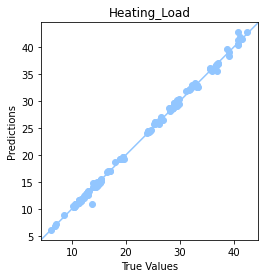

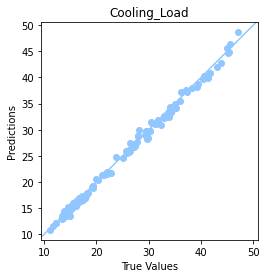

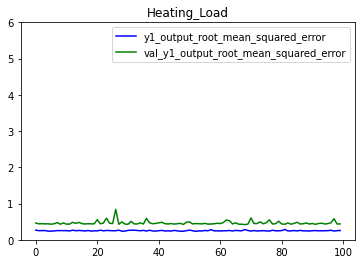

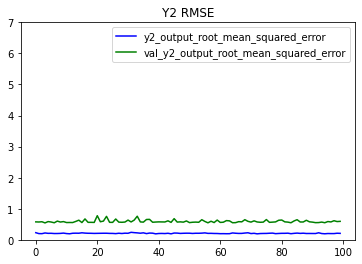

In [182]:
def plot_diff(y_true, y_pred, title = ""):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.axis("equal")
    plt.axis("square")
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history["val_" + metric_name], color = "green", label = "val_" + metric_name)
    plt.legend()
    plt.show()
Y_pred = model.predict(X_test)
plot_diff(Y_test[0], Y_pred[0], title = "Heating_Load")
plot_diff(Y_test[1], Y_pred[1], title = "Cooling_Load")
plot_metrics(metric_name = "y1_output_root_mean_squared_error", title = "Heating_Load", ylim = 6)
plot_metrics(metric_name = "y2_output_root_mean_squared_error", title = "Y2 RMSE", ylim = 7)

In [183]:
model_eval = model.evaluate(x = X_test, y = Y_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.5452 - y1_output_loss: 0.1924 - y2_output_loss: 0.3528 - y1_output_root_mean_squared_error: 0.4386 - y2_output_root_mean_squared_error: 0.5940


This model predicts heating and cooling loads very accurately, as shown by the low RMSE on both predictions and how closely the predictions adhere to the actual value lines.